# Example 3 - Posing the Inverse Problem

It is notoriously difficult to estimate uncertainties from Curie depth determinations. Intuitively, the fewer points in the power spectrum should result in higher uncertainty, but it is difficult to quantify these uncertainties in practise. For [Bouligand *et al.*, 2009](http://doi.wiley.com/10.1029/2009JB006494) it is difficult to determine the values of $\beta$ and $\Delta z$ since both control the slope of the power spectrum at low wavenumbers. Similarly, for [Tanaka *et al.*, 1999](http://linkinghub.elsevier.com/retrieve/pii/S0040195199000724) the lower and upper ranges of the power spectrum used to compute $z_b$ and $z_t$ is highly subjective and can result in significantly different Curie depths.

Here, we pose the problem of finding the Curie depth from the radial power spectrum within a Bayesian framework. Thus, we can effectively estimate the uncertainty of our Curie depth estimates.

### Contents

- [Bayesian inverse framework](#Bayesian-inverse-framework)
- [Metropolis-Hastings algorithm](#Metropolis-Hastings-algorithm)
- [Appraising the ensemble](#Appraising-the-ensemble)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

import pycurious

In [2]:
# load x,y,anomaly
mag_data = np.loadtxt("../../data/test_mag_data.txt")

nx, ny = 305, 305

x = mag_data[:,0]
y = mag_data[:,1]
d = mag_data[:,2].reshape(ny,nx)

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

In [3]:
grid = pycurious.CurieOptimise(d, xmin, xmax, ymin, ymax)

# pick the centroid
xpt = 0.5*(xmin + xmax)
ypt = 0.5*(ymin + ymax)

window_size = 200e3
subgrid = grid.subgrid(window_size, xpt, ypt)

## Bayesian inverse framwork

Geophysical inversion often casts problems in a Bayesian framework, where information on input parameters are represented in probabilistic terms. The solution is given by _a posteriori_ probability, $P(\mathbf{m}|\mathbf{d})$, which is proportional to the product of the likelihood function $P(\mathbf{d}|\mathbf{m})$ and the _a priori_ probability $P(\mathbf{m})$,

$$
P(\mathbf{m}|\mathbf{d}) \propto P(\mathbf{d}|\mathbf{m}) \cdot P(\mathbf{m})
$$

The likelihood function is the probability of reproducing the data $\mathbf{d}$ given a particular model $\mathbf{m}$, and the _a priori_ model is what we know about the model before assimilating the data. The posterior probability can be evaluated through an objective function, $S(\mathbf{m})$, which jointly compares the misfit between data and prior information, $\mathbf{m}_p$,

$$
P(\mathbf{m}|\mathbf{d}) = A \, \exp (-S(\mathbf{m}))
$$

where $A$ is a constant. We seek the maximum _a posteriori_ (MAP) estimate, which may be obtained by minimising the $\ell_p$-norm objective function if data and prior information are both uncorrelated,

$$
S(\mathbf{m}) = \frac{1}{s} \sum_{i} \frac{\vert g^i(\mathbf{m}) - d^i \vert^s}{(\sigma^i_d)^s} + \frac{1}{r} \sum_{j} \frac{\vert \mathrm{m}^j - \mathrm{m}^j_p \vert^r}{(\sigma^j_p)^r}
$$

where $\mathbf{g}(\mathbf{m})$ is the forward operator that forms an explicit link with the data. In our case $\mathbf{g}(\mathbf{m}) = \Phi$ and the objective function quantifies how well the analytic expression for the power spectrum, computed from model parameters $\Phi(\mathbf{m})$, fits the power spectrum computed from the magnetic anomaly, $\Phi_d$,

$$
S(\mathbf{m}) = \frac{1}{s} \sum_i \frac{\lvert \Phi^i(\mathbf{m}) - \Phi_d^i \lvert^s}{(\sigma_{\Phi}^i)^s} + \frac{1}{r} \sum_{j} \frac{\vert \mathrm{m}^j - \mathrm{m}^j_p \vert^r}{(\sigma^j_p)^r}
$$

By default, PyCurious assumes Gaussian uncertainties on $\Phi$ ($s=2$), and a uniform prior over a large range ($r=\infty$) for each model parameter where $-\sigma_p^j \leq \mathrm{m}^j - \mathrm{m}_p^j \leq +\sigma_p^j$. The prior can easily be defined by the user as we will demonstrate later. We have already covered the `optimise` method that uses gradient-based optimisation to quickly iterate to the MAP estimate in [Ex2-Compute-Curie-depth](./Ex2-Compute-Curie-depth.ipynb).


> **Note:** The objective function can be accessed (and modified) under `grid.objective_function`.

In [4]:

beta_opt, zt_opt, dz_opt, C_opt = grid.optimise(window_size, xpt, ypt, taper=None)

k, Phi, sigma_Phi = grid.radial_spectrum(subgrid, taper=None)

# define a range of parameters over which to analyse the misfit
# use the optimum parameters to help constrain an appropriate range
nb = 50
beta_range = np.linspace(beta_opt - 0.5, beta_opt + 0.5,nb)
dz_range = np.linspace(dz_opt - 5.0, dz_opt + 5.0, nb)

# constant values for zt and C
zt = zt_opt
C = C_opt

# misfit matrix
misfit = np.zeros((nb,nb))

for i, beta in enumerate(beta_range):
    for j, dz in enumerate(dz_range):

        m = [beta, zt, dz, C]
        
        misfit[i,j] = grid.min_func(m, k, Phi, sigma_Phi)


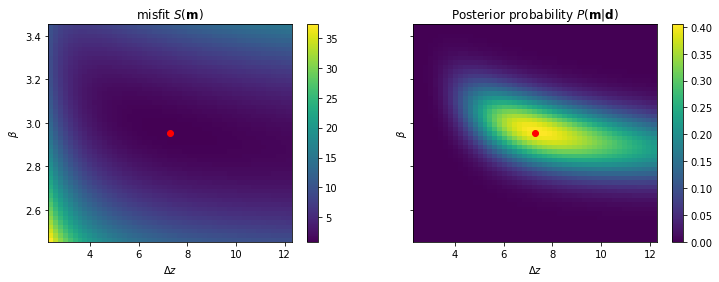

In [5]:
# Plot joint probability
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(12,4))

X, Y = np.meshgrid(dz_range, beta_range)

im1 = ax1.pcolormesh(X, Y, misfit)
im2 = ax2.pcolormesh(X, Y, np.exp(-misfit))
ax1.scatter(dz_opt, beta_opt, c='r')
ax2.scatter(dz_opt, beta_opt, c='r')

ax1.set_ylabel(r"$\beta$")
ax2.set_ylabel(r"$\beta$")
ax1.set_xlabel(r"$\Delta z$")
ax2.set_xlabel(r"$\Delta z$")
ax1.set_title(r"misfit $S(\mathbf{m})$")
ax2.set_title(r"Posterior probability $P(\mathbf{m}|\mathbf{d})$")

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

## Metropolis-Hastings algorithm

A practical approach to sample the posterior is to use MCMC methods such as the Metropolis-Hastings algorithm. This implements a random walk where $k=1,2,\ldots,n$ for a Markov Chain $n$ samples long.

1. Generate a candidate $\mathbf{m}'$ for the next sample by picking from the prior distribution $P(\mathbf{m})$.
2. Calculate the acceptance ratio between each sample of the posterior $\alpha = P(\mathbf{m}'|\mathbf{d})/P(\mathbf{m}_{k}|\mathbf{d})$
3. Generate a random number $u: [0,1]$ which will be used to decide if a candidate is accepted or rejected.
    - accept if $u \leq \alpha$ and set $\mathbf{m}_{k+1} = \mathbf{m}'$
    - reject if $u > \alpha$ and set $\mathbf{m}_{k+1} = \mathbf{m}_k$ instead

The random walk should be initialised not too far from the MAP estimate. MCMC methods require tuning to adequately sample the posterior. Parameters to tweak include:

- `burnin`: the number of burn-in simulations
- `nsim`: total simulation after burnin
- `x_scale`: scaling factor $\gamma$ to generate a new candidate $\mathbf{m}' = \gamma \mathbf{m}$.

```python
posterior = metropolis_hastings(window_size, xpt, ypt, nsim, burnin, x_scale)
```

In [140]:
from scipy.signal import tukey

window_size = 304e3

def tukey_taper(A):
    return tukey(A, alpha=0.1)

In [149]:
k, Phi, sigma_Phi = grid.radial_spectrum(subgrid, taper=tukey_taper)

x_scale = [0.25, 0.1, 1.0, 1.0]

burnin = 1000
nsim = 100000

# C can be initialised close to its MAP very easily
posterior = grid.metropolis_hastings(window_size, xpt, ypt, nsim, burnin, x_scale, C=Phi.mean(), taper=tukey_taper)

In [17]:
%%timeit
posterior = grid.metropolis_hastings(window_size, xpt, ypt, nsim, burnin, x_scale, C=Phi.mean(), taper=None)

10.1 s ± 426 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Appraising the ensemble

How best to visualise the ensemble after the MCMC simulation? We cover some of the following:

- Histograms
- Scatter plots & joint probabilities
- Trajectory of the random walk
- MAP estimate

/usr/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


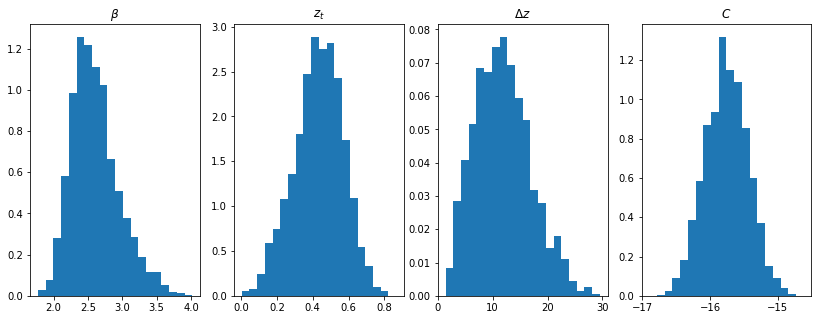

In [150]:
labels = [r'$\beta$', r'$z_t$', r'$\Delta z$', r'$C$']

fig, axes = plt.subplots(1,4, figsize=(14,5))
for i, ax in enumerate(axes):
    ax.hist(posterior[i], bins=20, normed=True)
    ax.set_title(labels[i])

In [151]:

from scipy.stats import skewnorm

fit_res = stats.skewnorm.fit(posterior[2])
skew_pdf = stats.skewnorm(*fit_res)

skew_pdf.mean()

11.80734126384078

In [152]:
np.mean(posterior[0]), np.mean(posterior[1])

(2.6063838927177105, 0.43236684227774075)

In [120]:

mode(posterior, axis=1)

KeyboardInterrupt: 

/usr/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


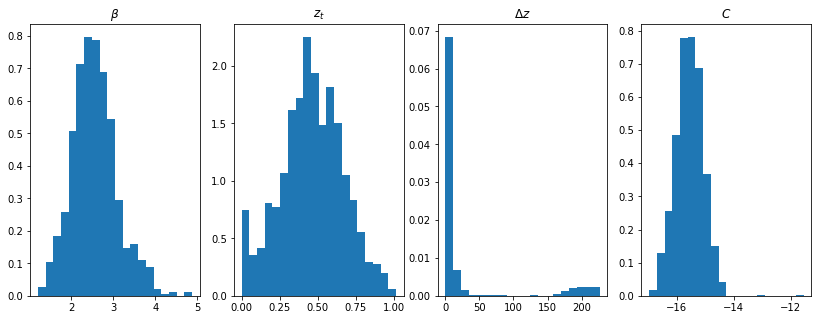

In [154]:

grid.bounds = [(None,None)]*4
grid.bounds = [(0,None), (0,None), (0,None), (None,None)]
posterior = grid.sensitivity(window_size, xpt, ypt, 1000, taper=None)

labels = [r'$\beta$', r'$z_t$', r'$\Delta z$', r'$C$']

fig, axes = plt.subplots(1,4, figsize=(14,5))
for i, ax in enumerate(axes):
    ax.hist(posterior[i], bins=20, normed=True)
    ax.set_title(labels[i])

In [105]:
grid.optimise(window_size, xpt, ypt,)

array([  2.7409911 ,   0.38893203,   8.57367629, -18.46820934])

In [15]:
%%timeit
posterior = grid.sensitivity(window_size, xpt, ypt, 1000, taper=None)

17.3 s ± 1.08 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [101]:
from scipy.optimize import minimize

def sensitivity(
    self,
    window,
    xc,
    yc,
    nsim,
    beta=3.0,
    zt=1.0,
    dz=10.0,
    C=5.0,
    taper=np.hanning,
    process_subgrid=None,
    **kwargs
):
    """
    Iterate through a list of centroids to compute the mean and
    standard deviation of \\( \\beta, z_t, \\Delta z, C \\) by
    perturbing their prior distributions
    (if provided by the user - see add_prior).

    Args:
        nsim : int
            number of Monte Carlo simulations
        window : float
            size of window in metres
        xc : float
            centroid x values
        yc : float
            centroid y values
        nsim : int
            number of simulations
        beta : float
            starting fractal parameter 
        zt : float
            starting top of magnetic layer
        dz : float
            starting thickness of magnetic layer
        C : float
            starting field constant


    Returns:
        beta : ndarray shape (nsim,)
            fractal parameters
        zt : ndarray shape (nsim,)
            top of magnetic layer
        dz : ndarray shape (nsim,)
            thickness of magnetic layer
        C : ndarray shape (nsim,)
            field constant
    """
    if process_subgrid is None:
        # dummy function
        def process_subgrid(subgrid):
            return subgrid

    samples = np.empty((nsim, 4))
    x0 = np.array([beta, zt, dz, C])

    use_keys = []
    for key in self.prior_pdf:
        prior_pdf = self.prior_pdf[key]
        if prior_pdf is not None:
            use_keys.append(key)

    # get subgrid
    subgrid = self.subgrid(window, xc, yc)
    subgrid = process_subgrid(subgrid)

    # compute radial spectrum
    k, Phi, sigma_Phi = self.radial_spectrum(subgrid, taper=taper, **kwargs)

    for sim in range(0, nsim):
        # randomly generate new prior values within PDF
        for key in use_keys:
            prior_pdf = self.prior_pdf[key]
            self.prior[key][0] = prior_pdf.rvs()

        # minimise function
        rPhi = np.random.normal(Phi, sigma_Phi)
        res = minimize(
            self.min_func, x0, args=(k, rPhi, sigma_Phi), method='L-BFGS-B')
        samples[sim] = res.x

    # restore priors
    for key in use_keys:
        prior_pdf = self.prior_pdf[key]
        self.prior[key] = list(prior_pdf.args)

    return list(samples.T)

In [102]:
posterior = sensitivity(grid, window_size, xpt, ypt, 1000, taper=None)

/usr/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


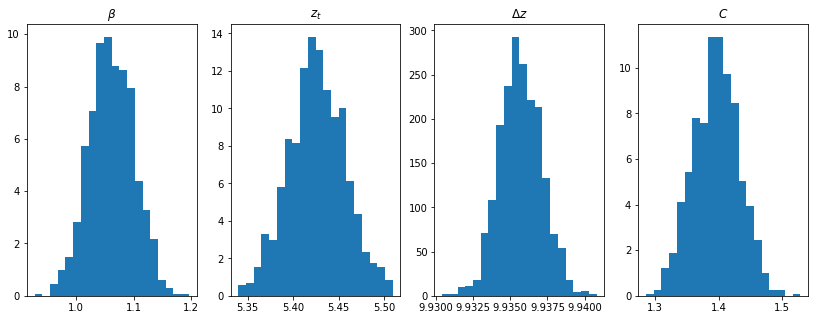

In [103]:
labels = [r'$\beta$', r'$z_t$', r'$\Delta z$', r'$C$']

fig, axes = plt.subplots(1,4, figsize=(14,5))
for i, ax in enumerate(axes):
    ax.hist(posterior[i], bins=20, normed=True)
    ax.set_title(labels[i])

Below are some joint probabilities visualised with the trajectory of the random walk.

In [ ]:
# Plot joint probability and trajectory of random walk
fig, (ax1,ax2) = plt.subplots(1,2,  figsize=(12,4))


H1, xedges, yedges = np.histogram2d(posterior[1], posterior[3], normed=True)
X1, Y1 = np.meshgrid(xedges, yedges)

H2, xedges, yedges = np.histogram2d(posterior[2], posterior[0], normed=True)
X2, Y2 = np.meshgrid(xedges, yedges)


ax1.pcolormesh(X1, Y1, H1)
ax1.plot(posterior[1], posterior[3], c='w')

ax2.pcolormesh(X2, Y2, H2)
ax2.plot(posterior[2], posterior[0], c='w')

ax1.set_xlabel(r"$z_t$")
ax1.set_ylabel(r"$C$")
ax2.set_xlabel(r"$\Delta z$")
ax2.set_ylabel(r"$\beta$")

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

In [ ]:
mode_result = stats.mode(np.vstack(posterior).T, axis=0)

x_opt1 = grid.optimise(window_size, xpt, ypt, taper=None)
x_opt2 = mode_result.mode.ravel()

str_fmt = "beta = {:.2f}  zt = {:.2f}  dz = {:5.2f}  C = {:.2f}"

print(str_fmt.format(*x_opt1))
print(str_fmt.format(*x_opt2))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(12,4))

Phi_opt1 = pycurious.bouligand2009(k, *x_opt1)
Phi_opt2 = pycurious.bouligand2009(k, *x_opt2)

ax1.plot(k, Phi, 'o', c='0.5')
ax1.plot(k, Phi_opt1, linewidth=2, label='MAP (optimised)')
ax1.plot(k, Phi_opt2, linewidth=2, label='MAP (MCMC)')
ax2.semilogx(k, Phi, 'o', c='0.5')
ax2.semilogx(k, Phi_opt1, linewidth=2, label='MAP (optimised)')
ax2.semilogx(k, Phi_opt2, linewidth=2, label='MAP (MCMC)')
# ax2.semilogx(k, S2)

ax1.set_ylabel('radial power spectrum')
ax1.set_xlabel('wavenumber (rad/km)')
ax2.set_xlabel('log wavenumber (rad/km)')

ax1.legend()
ax2.legend()

The MAP estimate obtained from `grid.optimise` should be identical to that from `grid.metropolis_hastings`, but may in differ in practice if `nsim` is too few or `x_scale` is not properly tuned. Running multiple chains in parallel should alleviate most concerns. Otherwise parts of the probability space may be non-unique.